In [10]:
import sys, os

# Указываем Spark'у, какой Python использовать
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [11]:
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType, StringType, DoubleType
import logging
import colorlog
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pyspark.sql.functions import col, when, lit, isnan
from pyspark.sql.types import StringType

In [12]:
class Logger:
    _logger = (
        None  # Используем статическую переменную для хранения единственного экземпляра
    )

    @staticmethod
    def get_logger():
        if Logger._logger is None:
            handler = colorlog.StreamHandler()
            handler.setFormatter(
                colorlog.ColoredFormatter("%(log_color)s%(levelname)s: %(message)s")
            )

            Logger._logger = logging.getLogger("data_pipeline")
            Logger._logger.setLevel(logging.INFO)

            # Проверяем, не добавлен ли уже обработчик
            if not Logger._logger.hasHandlers():
                Logger._logger.addHandler(handler)

        return Logger._logger

In [13]:
class EDA:
    def __init__(self, df: pd.DataFrame):
        """
        Инициализация класса EDA.
        """
        self.df = df

    def show_info(self):
        """Выводит информацию о данных."""
        print("📊 Общая информация о данных:")
        print(self.df.info())

    def show_missing_values(self):
        """Показывает количество пропущенных значений в каждой колонке."""
        missing_values = self.df.isnull().sum()
        total_missing = missing_values.sum()

        if total_missing > 0:
            print(f"⚠️ Пропущенных значений: {total_missing}")
            print(missing_values[missing_values > 0])
        else:
            print("✅ В данных нет пропущенных значений.")

    def show_missing_rows(self):
        """Выводит строки, в которых есть пропущенные значения."""
        missing_rows = self.df[self.df.isnull().any(axis=1)]
        print(f"🔍 Найдено строк с пропущенными значениями: {len(missing_rows)}")
        display(missing_rows.head(10))  # Показываем первые 10 строк

    def show_duplicates(self):
        """Находит дубликаты в датасете."""
        duplicate_count = self.df.duplicated().sum()
        print(f"⚠️ Найдено дубликатов: {duplicate_count}")

    def show_summary(self):
        """Выводит статистическую сводку данных."""
        print("📊 Статистическая сводка данных:")
        print(tabulate(self.df.describe(), headers="keys", tablefmt="grid"))

    def plot_missing_values(self):
        """Визуализация пропущенных значений."""
        plt.figure(figsize=(10, 6))
        sns.heatmap(self.df.isnull(), cbar=False, cmap="viridis")
        plt.title("Карта пропущенных значений")
        plt.show()

    def dataset_shape(self):
        """Выводит размер датасета (число строк и колонок)."""
        print("\n📏 Размер датасета:")
        print(f"Строк: {self.df.shape[0]}, Колонок: {self.df.shape[1]}")

    def dataset_custom_info(self):
        """Выводит информацию о каждой колонке: наличие `NaN`, тип данных."""
        print("\n📊 Детальная информация о колонках:")
        info_table = pd.DataFrame(
            {
                "Column": self.df.columns,
                "Has_Nulls": self.df.isnull().any(),
                "Dtype": self.df.dtypes,
            }
        )
        display(info_table)

    def sample_data(self, n=5):
        """Выводит первые `n` строк датасета."""
        print(f"\n📊 Первые {n} строк датасета:")
        display(self.df.head(n))

    def perform_full_eda(self):
        """Запускает полный EDA-анализ."""
        self.show_info()
        self.dataset_shape()
        self.dataset_custom_info()
        self.show_missing_values()
        self.show_missing_rows()
        self.show_duplicates()
        self.show_summary()
        self.plot_missing_values()
        self.sample_data()

In [14]:
class PreprocessingPipeline:
    def __init__(self, df: pd.DataFrame):
        """Инициализация Spark и загрузка данных (df уже с pd.NA вместо пропусков)"""
        self.spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()
        # df уже содержит pd.NA
        self.df = self.spark.createDataFrame(df)
        self.logger = Logger.get_logger()

    def remove_empty_rows(self):
        """
        1) Заменяем числовые NaN на NULL
        2) Удаляем полностью пустые строки (все поля None).
        3) Удаляем строки, где заполнен только 'Order ID', а все остальные поля None.
        """
        self.logger.info("🗑 Приведение NaN -> NULL в числовых столбцах...")
        # Шаг 1. Пройти по столбцам и заменить NaN на None, чтобы Spark видел их как NULL
        for field in self.df.schema.fields:
            # Если тип столбца float/double, то заменяем NaN -> None
            if field.dataType in (FloatType(), DoubleType()):
                col_name = field.name
                self.df = self.df.withColumn(
                    col_name, when(isnan(col(col_name)), None).otherwise(col(col_name))
                )

        self.logger.info("🗑 Удаление полностью пустых строк...")
        before_count = self.df.count()

        # Шаг 2. dropna(how="all") - удаляем строки, где ВСЕ колонки NULL
        self.df = self.df.na.drop(how="all")
        after_count = self.df.count()
        removed_all = before_count - after_count

        if removed_all > 0:
            self.logger.warning(f"⚠️ Удалено {removed_all} полностью пустых строк.")
        else:
            self.logger.info("✅ Полностью пустых строк не обнаружено.")

        # Шаг 3. Удаляем строки, где заполнен только 'Order ID' (остальные NULL)
        self.logger.info("🗑 Удаление строк, где кроме 'Order ID' все поля NULL...")
        columns_except_id = [c for c in self.df.columns if c != "Order ID"]

        cond_all_null_except_id = None
        for c in columns_except_id:
            is_null_col = col(c).isNull()
            cond_all_null_except_id = (
                is_null_col
                if cond_all_null_except_id is None
                else (cond_all_null_except_id & is_null_col)
            )

        before_count2 = self.df.count()
        # Фильтруем строки: оставляем те, где не выполняется условие «все NULL кроме ID»
        self.df = self.df.filter(~cond_all_null_except_id)
        after_count2 = self.df.count()
        removed_only_id = before_count2 - after_count2

        if removed_only_id > 0:
            self.logger.warning(
                f"⚠️ Удалено {removed_only_id} строк, где заполнен только 'Order ID'."
            )
        else:
            self.logger.info("✅ Не обнаружено строк, где заполнен только 'Order ID'.")

    def drop_duplicates(self):
        """Удаляет дубликаты по 'Order ID'."""
        self.logger.info("🗑 Удаление дубликатов по 'Order ID'...")
        before_count = self.df.count()
        self.df = self.df.dropDuplicates(["Order ID"])
        after_count = self.df.count()
        removed = before_count - after_count
        if removed > 0:
            self.logger.warning(f"⚠️ Удалено {removed} дубликатов по 'Order ID'.")
        else:
            self.logger.info("✅ Дубликаты по 'Order ID' не найдены.")

    def handle_missing_values(self):
        """
        1) Согласуем Date и Year (берём год из Date, если они различаются или Year пуст).
        2) Заполняем числовые пропуски (среднее, 0, и т.д.).
        3) Заполняем строковые пропуски ('Unknown').
        """
        self.logger.info("🛠 Обработка пропущенных значений...")

        # 1) Согласование Date и Year
        self.logger.info("🔄 Согласование 'Date' и 'Year'...")

        cond_date_year_diff = (
            F.col("Date").isNotNull()
            & F.col("Year").isNotNull()
            & (F.year(F.col("Date")) != F.col("Year"))
        )
        rows_diff = self.df.filter(cond_date_year_diff).count()

        cond_date_no_year = F.col("Date").isNotNull() & F.col("Year").isNull()
        rows_no_year = self.df.filter(cond_date_no_year).count()

        # Если год не совпадает или Year пуст, берём год из колонки Date
        self.df = self.df.withColumn(
            "Year",
            when(
                cond_date_no_year | cond_date_year_diff, F.year(col("Date"))
            ).otherwise(col("Year")),
        )

        total_fixed = rows_diff + rows_no_year
        if total_fixed > 0:
            self.logger.warning(
                f"⚠️ Исправлено Year в {total_fixed} строках (Year не совпадал или был пуст)."
            )
        else:
            self.logger.info("✅ Не нашли расхождений между Date и Year.")

        # 2) Заполняем числовые пропуски
        self.logger.info("🔢 Заполнение числовых пропусков...")
        # Приводим Customer Age к float
        self.df = self.df.withColumn(
            "Customer Age", col("Customer Age").cast(FloatType())
        )

        mean_age = self.df.agg(F.mean("Customer Age")).collect()[0][0] or 30
        mean_cost = self.df.agg(F.mean("Cost")).collect()[0][0] or 0
        mean_ucost = self.df.agg(F.mean("Unit Cost")).collect()[0][0] or 0
        mean_uprice = self.df.agg(F.mean("Unit Price")).collect()[0][0] or 0

        numeric_cols = [
            "Number",
            "Year",
            "Customer Age",
            "Quantity",
            "Unit Cost",
            "Unit Price",
            "Cost",
        ]
        before_num = {
            c: self.df.filter(F.col(c).isNull()).count() for c in numeric_cols
        }

        self.df = self.df.fillna(
            {
                "Number": 0,
                "Year": 2024,
                "Customer Age": mean_age,
                "Quantity": 1,
                "Unit Cost": mean_ucost,
                "Unit Price": mean_uprice,
                "Cost": mean_cost,
            }
        )

        total_num_filled = sum(before_num.values())
        if total_num_filled > 0:
            self.logger.warning(
                f"⚠️ Заполнено ВСЕГО {total_num_filled} пропусков (числовые)."
            )
        else:
            self.logger.info("✅ Пропусков в числовых колонках не было.")

        # 3) Заполняем строковые пропуски
        self.logger.info("🔤 Заполнение строковых пропусков 'Unknown'...")
        cat_cols = [
            "Customer Gender",
            "Country",
            "State",
            "Product Category",
            "Sub Category",
            "Month",
        ]
        before_cat = {c: self.df.filter(F.col(c).isNull()).count() for c in cat_cols}

        self.df = self.df.fillna(
            {
                "Customer Gender": "Unknown",
                "Country": "Unknown",
                "State": "Unknown",
                "Product Category": "Unknown",
                "Sub Category": "Unknown",
                "Month": "Unknown",
            }
        )

        total_cat_filled = sum(before_cat.values())
        if total_cat_filled > 0:
            self.logger.warning(
                f"⚠️ Заполнено ВСЕГО {total_cat_filled} пропусков (строковые)."
            )
        else:
            self.logger.info("✅ Пропусков в строковых колонках не было.")

    def check_logic(self):
        """
        1) Unit Cost <= Unit Price
        2) Cost = Q * UnitPrice
        3) Customer Age ∈ [0..100]
        """
        self.logger.info("🔍 Проверка логики данных...")

        # 1) Unit Cost <= Unit Price
        cond_cost_bigger = col("Unit Cost") > col("Unit Price")
        n_cost_bigger = self.df.filter(cond_cost_bigger).count()
        self.df = self.df.withColumn(
            "Unit Cost",
            when(cond_cost_bigger, col("Unit Price")).otherwise(col("Unit Cost")),
        )
        if n_cost_bigger > 0:
            self.logger.warning(
                f"⚠️ В {n_cost_bigger} строках UnitCost>UnitPrice, исправлено."
            )

        # 2) Cost = Q * UnitPrice
        cond_wrong_cost = col("Cost") != col("Quantity") * col("Unit Price")
        fix_cost = self.df.filter(cond_wrong_cost).count()
        self.df = self.df.withColumn(
            "Cost",
            when(cond_wrong_cost, col("Quantity") * col("Unit Price")).otherwise(
                col("Cost")
            ),
        )
        if fix_cost > 0:
            self.logger.warning(
                f"⚠️ В {fix_cost} строках пересчитан Cost (Q*UnitPrice)."
            )

        # 3) Customer Age ∈ [0..100]
        avg_age = self.df.agg(F.mean("Customer Age")).collect()[0][0] or 30
        cond_age = (col("Customer Age") < 0) | (col("Customer Age") > 100)
        bad_age = self.df.filter(cond_age).count()
        self.df = self.df.withColumn(
            "Customer Age", when(cond_age, lit(avg_age)).otherwise(col("Customer Age"))
        )
        if bad_age > 0:
            self.logger.warning(
                f"⚠️ Найдено {bad_age} строк, где Age вне [0..100], исправлено."
            )

    def enforce_schema(self):
        """Приведение типов"""
        self.logger.info("📏 Приведение типов данных...")
        self.df = (
            self.df.withColumn("Order ID", col("Order ID").cast(IntegerType()))
            .withColumn("Number", col("Number").cast(IntegerType()))
            .withColumn("Year", col("Year").cast(IntegerType()))
            .withColumn("Customer Age", col("Customer Age").cast(IntegerType()))
            .withColumn("Quantity", col("Quantity").cast(IntegerType()))
            .withColumn("Unit Cost", col("Unit Cost").cast(FloatType()))
            .withColumn("Unit Price", col("Unit Price").cast(FloatType()))
            .withColumn("Cost", col("Cost").cast(FloatType()))
            .withColumn("Customer Gender", col("Customer Gender").cast(StringType()))
            .withColumn("Country", col("Country").cast(StringType()))
            .withColumn("State", col("State").cast(StringType()))
            .withColumn("Product Category", col("Product Category").cast(StringType()))
            .withColumn("Sub Category", col("Sub Category").cast(StringType()))
        )

    def validate_integrity(self):
        self.logger.info("🔍 Проверка целостности данных (убрали год).")

        # только проверяем Age >= 18, если желаете
        cond_underage = col("Customer Age") < 18
        underage_count = self.df.filter(cond_underage).count()
        if underage_count > 0:
            self.logger.warning(
                f"⚠️ Найдено {underage_count} строк с Age<18, исправляем..."
            )
            self.df = self.df.withColumn(
                "Customer Age",
                when(cond_underage, lit(18)).otherwise(col("Customer Age")),
            )

    def run(self):
        # 1) Удаляем пустые строки
        self.remove_empty_rows()
        # 2) Дубликаты
        self.drop_duplicates()
        # 3) Пропуски
        self.handle_missing_values()
        # 4) Логика
        self.check_logic()
        # 5) Типы
        self.enforce_schema()
        # 6) Целостность (без проверки на Year, только Age>=18)
        self.validate_integrity()

        self.logger.info("🔽 Сортировка по 'Order ID'...")
        self.df = self.df.sort(F.col("Order ID"))
        final_count = self.df.count()
        self.logger.info(f"✅ Финал: {final_count} строк осталось.")
        return self.df.toPandas()

In [15]:
class DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.logger = Logger.get_logger()

    def load_data(self):
        self.logger.info("📥 Загрузка данных...")

        # Явно указываем пустые значения
        df = pd.read_excel(
            self.file_path,
            na_values=["", " ", "NA", "NaN", "N/A", "NULL", None, "Missing value"],
            keep_default_na=True,
        )

        # Принудительно заменяем пустые строки на NaN
        df.replace(r"^\s*$", pd.NA, regex=True, inplace=True)

        return df

    def save_data(self, df):
        output_path = os.path.join(
            os.path.dirname(self.file_path), "Осіпов_Go IT Data.xlsx"
        )
        self.logger.info(f"📤 Сохранение обработанных данных в {output_path}...")
        df.to_excel(output_path, index=False)
        self.logger.info("✅ Файл успешно сохранен.")

In [16]:
file_path = "task_2.xlsx"

# Загружаем данные
processor = DataProcessor(file_path)
df = processor.load_data()

INFO: 📥 Загрузка данных...


📊 Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34884 entries, 0 to 34883
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order ID          34842 non-null  float64       
 1   Date              34822 non-null  datetime64[ns]
 2   Number            0 non-null      float64       
 3   Year              34866 non-null  float64       
 4   Month             34866 non-null  object        
 5   Customer Age      34866 non-null  float64       
 6   Customer Gender   34866 non-null  object        
 7   Country           34866 non-null  object        
 8   State             34866 non-null  object        
 9   Product Category  34866 non-null  object        
 10  Sub Category      34833 non-null  object        
 11  Quantity          34840 non-null  float64       
 12  Unit Cost         34843 non-null  float64       
 13  Unit Price        34866 non-null  float64      

,Column,Has_Nulls,Dtype
Order ID,Order ID,True,float64
Date,Date,True,datetime64[ns]
Number,Number,True,float64
Year,Year,True,float64
Month,Month,True,object
Customer Age,Customer Age,True,float64
Customer Gender,Customer Gender,True,object
Country,Country,True,object
State,State,True,object
Product Category,Product Category,True,object


⚠️ Пропущенных значений: 67596
Order ID               42
Date                   62
Number              34884
Year                   18
Month                  18
Customer Age           18
Customer Gender        18
Country                18
State                  18
Product Category       18
Sub Category           51
Quantity               44
Unit Cost              41
Unit Price             18
Cost                   18
Column1             32310
dtype: int64
🔍 Найдено строк с пропущенными значениями: 34884


,Order ID,Date,Number,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Column1
0,0.0,2016-02-19,NaN,2024.0,February,29.0,Famale,United States,Washington,Accessories,Tires and Tubes,1.0,80.00,109.000000,80.0,NaN
1,1.0,2016-02-20,NaN,2024.0,February,29.0,Famale,United States,Washington,Clothing,Gloves,2.0,24.50,28.500000,49.0,NaN
2,2.0,2016-02-27,NaN,2024.0,February,29.0,Famale,United States,Washington,Accessories,Tires and Tubes,3.0,3.67,5.000000,11.0,NaN
3,3.0,2016-03-12,NaN,2024.0,March,29.0,Famale,United States,Washington,Accessories,Tires and Tubes,2.0,87.50,116.500000,175.0,NaN
4,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,2016-03-12,NaN,2024.0,March,29.0,Famale,United States,Washington,Accessories,Tires and Tubes,3.0,35.00,41.666667,105.0,NaN
6,5.0,2016-04-08,NaN,2024.0,April,29.0,Famale,United States,Washington,Accessories,Tires and Tubes,1.0,66.00,78.000000,66.0,NaN
7,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,6.0,2016-04-17,NaN,2024.0,April,29.0,Famale,United States,Washington,Accessories,Tires and Tubes,2.0,52.00,60.000000,104.0,NaN
9,7.0,2016-04-17,NaN,2024.0,April,29.0,Famale,United States,Washington,Accessories,Tires and Tubes,1.0,60.00,68.000000,60.0,NaN


⚠️ Найдено дубликатов: 16
📊 Статистическая сводка данных:
+-------+------------+-------------------------------+----------+-------------+----------------+--------------+-------------+--------------+-----------+-----------+
|       |   Order ID | Date                          |   Number |        Year |   Customer Age |     Quantity |   Unit Cost |   Unit Price |      Cost |   Column1 |
+=======+============+===============================+==========+=============+================+==============+=============+==============+===========+===========+
| count |   34842    | 34822                         |        0 | 34866       |     34866      | 34840        |   34843     | 34866        | 34866     |  2574     |
+-------+------------+-------------------------------+----------+-------------+----------------+--------------+-------------+--------------+-----------+-----------+
| mean  |   17442.2  | 2016-01-19 19:07:15.655620096 |      nan |  2023.57    |        36.3829 |     2.00244  |     3

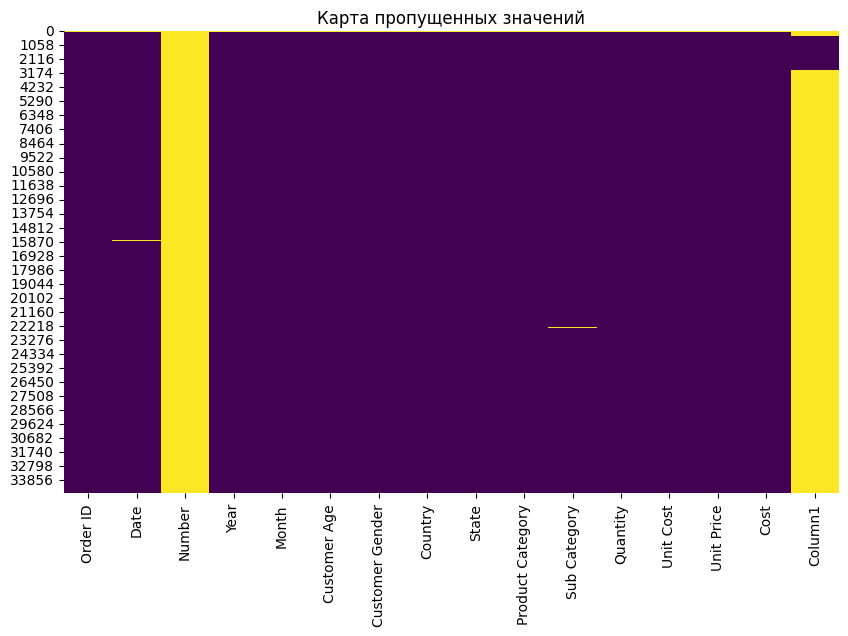


📊 Первые 5 строк датасета:


,Order ID,Date,Number,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Column1
0,0.0,2016-02-19,NaN,2024.0,February,29.0,Famale,United States,Washington,Accessories,Tires and Tubes,1.0,80.00,109.0,80.0,NaN
1,1.0,2016-02-20,NaN,2024.0,February,29.0,Famale,United States,Washington,Clothing,Gloves,2.0,24.50,28.5,49.0,NaN
2,2.0,2016-02-27,NaN,2024.0,February,29.0,Famale,United States,Washington,Accessories,Tires and Tubes,3.0,3.67,5.0,11.0,NaN
3,3.0,2016-03-12,NaN,2024.0,March,29.0,Famale,United States,Washington,Accessories,Tires and Tubes,2.0,87.50,116.5,175.0,NaN
4,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Выполняем EDA
eda = EDA(df)

eda.perform_full_eda()

In [18]:
# Запускаем пайплайн предобработки
pipeline = PreprocessingPipeline(df)
cleaned_data = pipeline.run()

INFO: 🗑 Приведение NaN -> NULL в числовых столбцах...
INFO: 🗑 Удаление полностью пустых строк...
INFO: ✅ Полностью пустых строк не обнаружено.                          
INFO: 🗑 Удаление строк, где кроме 'Order ID' все поля NULL...
INFO: ✅ Не обнаружено строк, где заполнен только 'Order ID'.           
INFO: 🗑 Удаление дубликатов по 'Order ID'...
INFO: 🛠 Обработка пропущенных значений...
INFO: 🔄 Согласование 'Date' и 'Year'...
INFO: 🔢 Заполнение числовых пропусков...
INFO: 🔤 Заполнение строковых пропусков 'Unknown'...
INFO: ✅ Пропусков в строковых колонках не было.                        
INFO: 🔍 Проверка логики данных...
INFO: 📏 Приведение типов данных...                                    
INFO: 🔍 Проверка целостности данных (убрали год).
INFO: 🔽 Сортировка по 'Order ID'...
INFO: ✅ Финал: 34843 строк осталось.                                   
25/02/21 08:49:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted b

In [19]:
# Сохраняем обработанный файл
processor.save_data(cleaned_data)

INFO: 📤 Сохранение обработанных данных в Осіпов_Go IT Data.xlsx...
INFO: ✅ Файл успешно сохранен.
